# Error estimation


In [251]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
import util, config, plots
import ipynbname
import pandas as pd
import numpy as np
import json
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate fake dataset

Text(0.5, 1.0, 'Quality assessment of the dataset: Observed vs True Frequency')

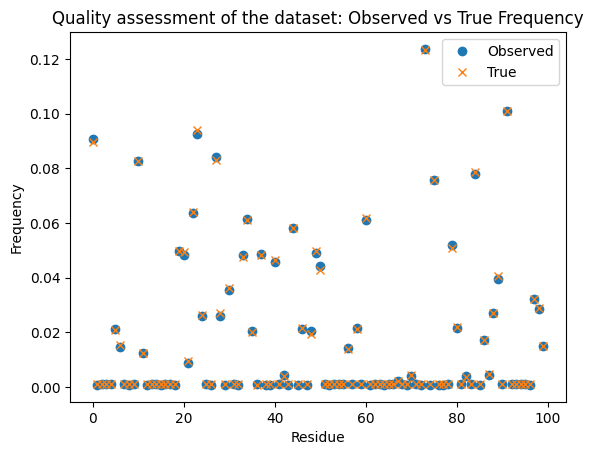

In [256]:
r = 100 # number of residues
N = 100000 # number of reads

def generate_dataset(N, r):
    true_mutation_rate = np.random.normal(0, 0.05, r)
    true_mutation_rate[true_mutation_rate < 0] = 0.001
    data = np.where(true_mutation_rate > np.random.rand(N, len(true_mutation_rate)), 1, 0) 
    return data, true_mutation_rate
    
def generate_sample(data, size_sample):
    return data[np.random.randint(0, N, size_sample)]

data, true_mutation_rate = generate_dataset(N, r)

plt.plot(data.sum(axis=0)/N, 'o')
plt.plot(true_mutation_rate, 'x')
plt.xlabel('Residue')
plt.ylabel('Frequency')
plt.legend(['Observed', 'True'])
plt.title('Quality assessment of the dataset: Observed vs True Frequency')

### Create a test sample


In [151]:

# sample is size_sample reads from data, randomly selected
size_sample = 2000

sample = generate_sample(data, size_sample)


# Bootstrap vs binomial distribution


## Bootstrap
### Define bootstrap function

In [152]:
def bootstrap(data, n=1000):
    """
    Bootstrap the data
    """
    n, r = data.shape
    res = np.zeros((n, r))
    for i in range(n):
        res[i] = data[np.random.randint(0, n, n)].sum(axis=0)
    return res

### Predict confidence intervals with bootstrap

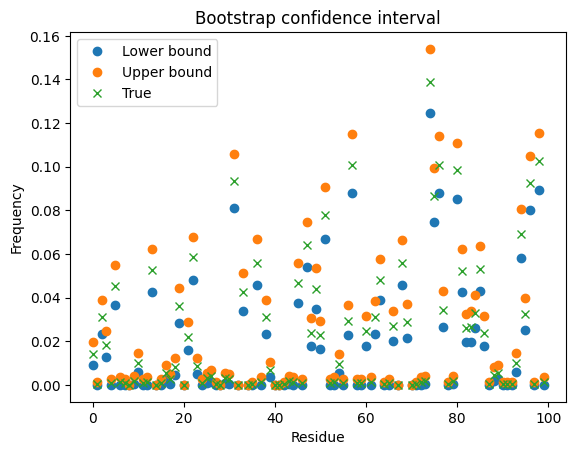

In [153]:
def predict_confidence_interval_bootstrap(data, bootstrap_iterations=1000):
    bs = bootstrap(sample, n=bootstrap_iterations)
    lower_bound, upper_bound = np.percentile(bs, [2.5, 97.5], axis=0)/size_sample
    return lower_bound, upper_bound
    
def plot_confidence_interval_bootstrap(data, lower_bound, upper_bound):
    plt.plot(lower_bound, 'o', label='Lower bound')
    plt.plot(upper_bound, 'o', label='Upper bound')
    mr = data.sum(axis=0)/size_sample
    plt.plot(mr, 'x', label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Bootstrap confidence interval')
    
plot_confidence_interval_bootstrap(sample, *predict_confidence_interval_bootstrap(sample))

## Binomial distribution

### Predict confidence intervals with binomial distribution 

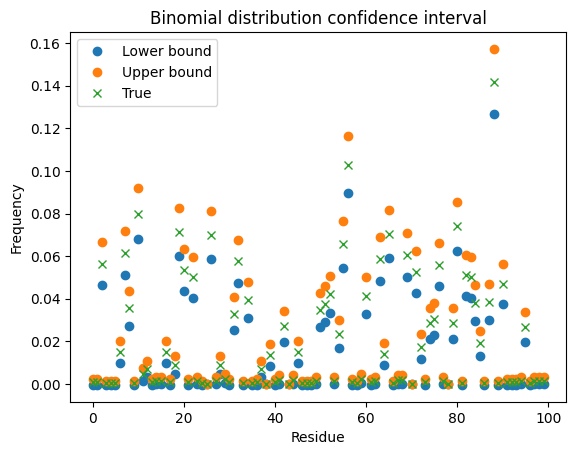

In [161]:

# start with the observed frequency, and the sample size, not the bitvector
observed_freq = sample.sum(axis=0)/size_sample

def predict_confidence_interval_binomial_distribution(observed_freq, size_sample):
    """
    Predict the confidence interval using the binomial distribution
    """
    lower_bound = observed_freq - 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    upper_bound = observed_freq + 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    return lower_bound, upper_bound
    
def plot_confidence_interval_binomial_distribution(observed_freq, lower_bound, upper_bound):
    plt.plot(lower_bound, 'o', label='Lower bound')
    plt.plot(upper_bound, 'o', label='Upper bound')
    plt.plot(observed_freq, 'x', label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Binomial distribution confidence interval')
    
plot_confidence_interval_binomial_distribution(observed_freq, *predict_confidence_interval_binomial_distribution(observed_freq, size_sample))

## Compare bootstrap and binomial distribution

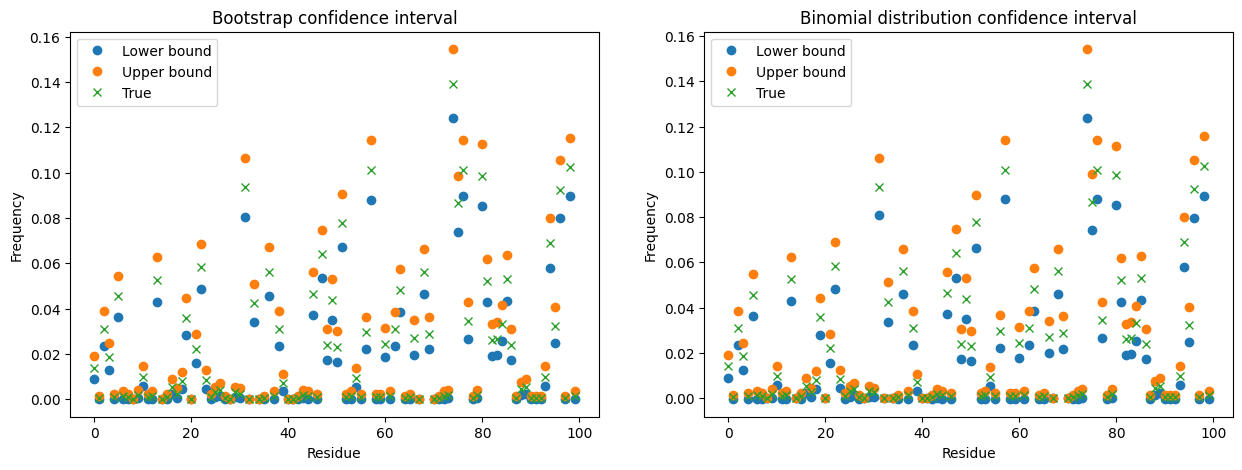

In [155]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confidence_interval_bootstrap(sample, *predict_confidence_interval_bootstrap(sample))
plt.subplot(1, 2, 2)
plot_confidence_interval_binomial_distribution(observed_freq, *predict_confidence_interval_binomial_distribution(observed_freq, size_sample))

## Access bootstrap performance
Predict a confidence interval for a sub-sample of the data, and make sure that the confidence interval contains the true value.

In [252]:
n_trials_per_dataset = 10
bootstrap_iterations = 1000
n_datasets = 10

bootstrap_failures = []
binomial_failures = []

for N in [500, 1000, 2000, 4000, 10000]:

    for n_dataset in range(n_datasets):
        
        # generate a new dataset
        data, true_mutation_rate = generate_dataset(N, r)

        fail_bootstrap, fail_binomial = [], []
        for _ in range(n_trials_per_dataset):
            
            # generate a new sample
            sample = generate_sample(data, size_sample)
            observed_freq = sample.sum(axis=0)/size_sample
            
            # count failures bootstrap
            lb_bs, ub_bs = predict_confidence_interval_bootstrap(sample, bootstrap_iterations=bootstrap_iterations)
            fail_bootstrap.append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])

            # count failures binomial
            lb_bin, ub_bin = predict_confidence_interval_binomial_distribution(observed_freq, size_sample)
            fail_binomial.append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])

        bootstrap_failures.append(fail_bootstrap)
        binomial_failures.append(fail_binomial)
        #print(f'{n_dataset}: Binomial: {np.mean(binomial_failures[-1])}% failure rate')
        #print(f'{n_dataset}: Bootstrap: {np.mean(bootstrap_failures[-1])}% failure rate')
        
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(bootstrap_failures).flatten(), 
            'Binomial': np.array(binomial_failures).flatten(), 
            'Trial' : np.repeat(np.arange(n_trials_per_dataset), n_datasets)
        })
    df = pd.melt(df, id_vars=['Trial'], value_vars=['Bootstrap', 'Binomial'], var_name='Method', value_name='Failure rate (%)')

    fig = px.box(df, x='Trial', y='Failure rate (%)', color='Method', title='Failure rate of the confidence interval methods for N = {}, r = {}, size_sample = {}, bootstrap_iterations = {}'.format(N, r, size_sample, bootstrap_iterations))
    fig.show()

ValueError: All arrays must be of the same length

## Conclusion
The bootstrap method is equivalent the binomial distribution.

Boostrapping isn't a super reliable method to get confidence intervals on the test set (it's not a good idea to use the test set to estimate the performance of the model). However, it's a good method to get confidence intervals on the training set.

# Alternative methods performance assessment

### Generate fake dataset


In [165]:
data, true_mutation_rate = generate_dataset(N, r)
sample = generate_sample(data, size_sample)



##  Wilson score 
### Define function

In [163]:
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = np.sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

### Predict confidence intervals with Wilson score


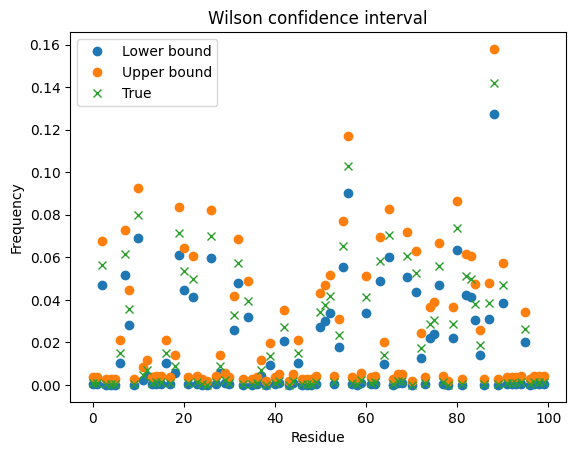

In [167]:
def plot_confidence_interval_wilson(observed_freq, lower_bound, upper_bound):
    plt.plot(lower_bound, 'o', label='Lower bound')
    plt.plot(upper_bound, 'o', label='Upper bound')
    plt.plot(observed_freq, 'x', label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Wilson confidence interval')
    
plot_confidence_interval_wilson(observed_freq, *wilson(observed_freq, size_sample))

## Clopper-Pearson 
### Define function

In [179]:
def clopper_pearson(*args):
    return sm.stats.proportion_confint(*args, method='beta')

### Predict confidence intervals with Clopper-Pearson 

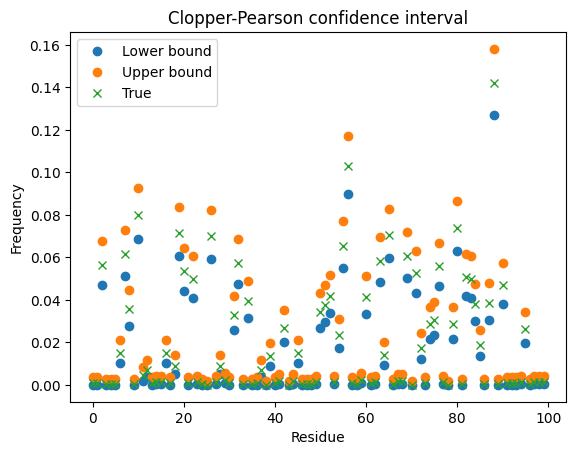

In [180]:
def plot_clopper_pearson(observed_freq, lower_bound, upper_bound):
    plt.plot(lower_bound, 'o', label='Lower bound')
    plt.plot(upper_bound, 'o', label='Upper bound')
    plt.plot(observed_freq, 'x', label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Clopper-Pearson confidence interval')
    
plot_clopper_pearson(observed_freq, *clopper_pearson(observed_freq*size_sample, size_sample))

## Agresti-Coull
### Define function

In [181]:
def agresti_coull(*args):
    return sm.stats.proportion_confint(*args, method='agresti_coull')

### Predict confidence intervals with Agresti-Coull

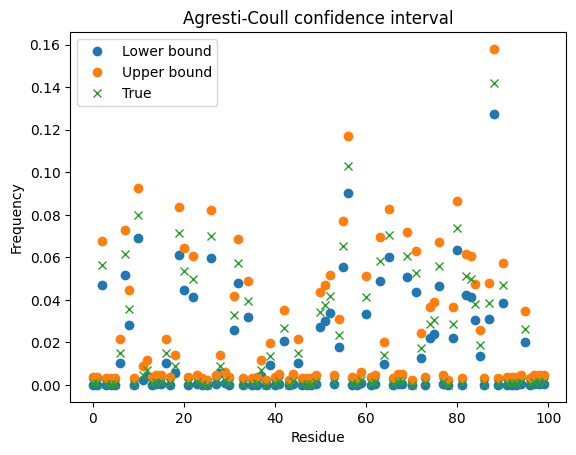

In [182]:
def plot_agresti_coull(observed_freq, lower_bound, upper_bound):
    plt.plot(lower_bound, 'o', label='Lower bound')
    plt.plot(upper_bound, 'o', label='Upper bound')
    plt.plot(observed_freq, 'x', label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Agresti-Coull confidence interval')
    
plot_agresti_coull(observed_freq, *agresti_coull(observed_freq*size_sample, size_sample))

## Perfomance assessment confidence intervals

In [257]:

n_trials_per_dataset = 10
bootstrap_iterations = 1000
n_datasets = 10
methods = ['bootstrap', 'binomial', 'wilson', 'clopper_pearson', 'agresti_coull']

for N in [500, 1000, 2000, 3000, 5000, 10000]:
    failures = {m:[] for m in methods}
    size_ci = {m:[] for m in methods}

    for n_dataset in range(n_datasets):
        
        # generate a new dataset
        data, true_mutation_rate = generate_dataset(N, r)

        fail = {m:[] for m in methods}
        size = {m:[] for m in methods}
        for _ in range(n_trials_per_dataset):
            
            # generate a new sample
            sample = generate_sample(data, size_sample)
            observed_freq = sample.sum(axis=0)/size_sample
            
            # count failures bootstrap
            lb_bs, ub_bs = predict_confidence_interval_bootstrap(sample, bootstrap_iterations=bootstrap_iterations)
            fail['bootstrap'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['bootstrap'].append(np.mean(ub_bs - lb_bs))
            
            # count failures binomial
            lb_bin, ub_bin = predict_confidence_interval_binomial_distribution(observed_freq, size_sample)
            fail['binomial'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['binomial'].append(np.mean(ub_bin - lb_bin))
            
            # count Wilson failures
            lb_wilson, ub_wilson = wilson(observed_freq, size_sample)
            fail['wilson'].append(100*np.logical_or(ub_wilson < true_mutation_rate, lb_wilson > true_mutation_rate).sum()/data.shape[1])
            size['wilson'].append(np.mean(ub_wilson - lb_wilson))
            
            # count Clopper-Pearson failures
            lb_cp, ub_cp = clopper_pearson(observed_freq*size_sample, size_sample)
            fail['clopper_pearson'].append(100*np.logical_or(ub_cp < true_mutation_rate, lb_cp > true_mutation_rate).sum()/data.shape[1])
            size['clopper_pearson'].append(np.mean(ub_cp - lb_cp))
            
            # count Agresti-Coull failures
            lb_ac, ub_ac = agresti_coull(observed_freq*size_sample, size_sample)
            fail['agresti_coull'].append(100*np.logical_or(ub_ac < true_mutation_rate, lb_ac > true_mutation_rate).sum()/data.shape[1])
            size['agresti_coull'].append(np.mean(ub_ac - lb_ac))

        for m in methods:
            failures[m].append(fail[m])
            size_ci[m].append(size[m])
        #    print(f'{n_dataset}: {m}: {np.mean(failures[m][-1])}% failure rate')
        #print('----------------------------------------------------------')
        
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(failures['bootstrap']).flatten(), 
            'Binomial': np.array(failures['binomial']).flatten(), 
            'Wilson': np.array(failures['wilson']).flatten(), 
            'Clopper-Pearson': np.array(failures['clopper_pearson']).flatten(), 
            'Agresti-Coull': np.array(failures['agresti_coull']).flatten(), 
            'Trial' : np.repeat(np.arange(n_trials_per_dataset), n_datasets)
        })
    df = pd.melt(df, id_vars=['Trial'], value_vars=[c for c in df.columns if not c == 'Trial'], var_name='Method', value_name='Failure rate (%)')

    fig = px.box(df, x='Trial', y='Failure rate (%)', color='Method', title='Failure rate of the confidence interval methods. N = {}'.format(N))
    fig.show()
    
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(size_ci['bootstrap']).flatten(), 
            'Binomial': np.array(size_ci['binomial']).flatten(), 
            'Wilson': np.array(size_ci['wilson']).flatten(), 
            'Clopper-Pearson': np.array(size_ci['clopper_pearson']).flatten(), 
            'Agresti-Coull': np.array(size_ci['agresti_coull']).flatten(), 
            'Trial' : np.repeat(np.arange(n_trials_per_dataset), n_datasets)
        })
    df = pd.melt(df, id_vars=['Trial'], value_vars=[c for c in df.columns if not c == 'Trial'], var_name='Method', value_name='Size of the CI')
    
    fig = px.box(df, x='Trial', y='Size of the CI', color='Method', title='Size of the confidence interval methods. N = {}'.format(N))
    fig.show()
    

## Conclusion

The alternative methods are more reliable than the bootstrap method.

##